In [1]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [18]:
panel_df = pd.read_csv('../data/processed/section_series_sum_small/panel.csv', index_col=['city','year'])
panel = xr.Dataset.from_dataframe(panel_df)
panel

<xarray.Dataset>
Dimensions:           (city: 1095, year: 21)
Coordinates:
  * city              (city) object 'aberdeen' 'abu dhabi' 'adana' ...
  * year              (year) int64 1993 1994 1995 1996 1997 1998 1999 2000 ...
Data variables:
    longitude         (city, year) float64 -2.1 -2.1 -2.1 -2.1 -2.1 -2.1 ...
    country           (city, year) int64 129 129 129 129 129 129 129 129 129 ...
    latitude          (city, year) float64 57.13 57.13 57.13 57.13 57.13 ...
    total_damage_usd  (city, year) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_affected    (city, year) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    insured_losses    (city, year) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    total_deaths      (city, year) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    earthquake_dummy  (city, year) bool False False False False False False ...
    Region            (city, year) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    Income group      (city, year) float64 0.0 0.

In [122]:
panel_df.reset_index().groupby('city').sum().sort_values(['earthquake_dummy','total_deaths'], ascending=False).head(25)

,year,longitude,country,latitude,total_damage_usd,total_affected,insured_losses,total_deaths,earthquake_dummy,Region,Income group,Lending category,region_sum_lum,terms_of_trade,country_sum_lum,inflation,imports,exports,sum_lum
city,,,,,,,,,,,,,,,,,,,
kerman,42063,"1,198.6546",1155,635.9474,"1,160,000.0000","741,990.0000",0.0000,"54,840.0000",5.0000,nan,nan,nan,"8,408,379.0000",nan,"173,975,895.0000",nan,nan,nan,"706,936.0000"
arequipa,42063,"-1,502.2350",2037,-344.3767,"300,050.0000","358,767.0000","50,000.0000",153.0000,5.0000,42.0000,63.0000,42.0000,"1,250,954.0000","-167,817,105,306.4408","16,015,628.0000",151.6025,433.6483,442.8304,"517,585.0000"
ica,42063,"-1,590.2367",2037,-295.4292,"600,000.0000","741,417.0000","200,000.0000",608.0000,4.0000,42.0000,63.0000,42.0000,"941,014.0000","-167,817,105,306.4408","16,015,628.0000",151.6025,433.6483,442.8304,"254,688.0000"
california,42063,"-1,531.8489",588,154.2889,"30,262,500.0000","52,964.0000","10,400,000.0000",62.0000,4.0000,42.0000,63.0000,42.0000,"106,296,714.0000","108,527,894,797,465.0000","39,139,594.0000",208.5501,408.8972,344.1696,"114,467.0000"
guerrero,42063,"-2,086.0000",1680,562.4500,"320,000.0000","100,128.0000","160,000.0000",62.0000,4.0000,42.0000,63.0000,42.0000,"5,270,137.0000","-5,665,356,812,504.7363","169,494,031.0000",206.8481,556.7282,541.0056,"90,057.0000"
akita,42063,"2,942.4500",1260,834.0500,"210,400,000.0000","371,571.0000","37,642,000.0000","19,869.0000",3.0000,0.0000,0.0000,0.0000,"4,523,624.0000","200,734,845,147,419.0625","226,183,132.0000",0.8379,241.5182,261.7655,"711,827.0000"
lima,42063,"-1,618.0500",2037,-253.0500,"1,800,000.0000","1,996,341.0000","600,000.0000","1,782.0000",3.0000,42.0000,63.0000,42.0000,"1,227,003.0000","-167,817,105,306.4408","16,015,628.0000",151.6025,433.6483,442.8304,"1,744,952.0000"
jambi,42063,"2,175.9500",1134,-33.6000,"2,700,000.0000","3,051,583.0000","100,000.0000","1,304.0000",3.0000,0.0000,42.0000,42.0000,"1,214,863.0000","1,742,867,964,636,658.2500","65,289,956.0000",226.3851,567.2992,644.7853,"280,539.0000"
bengkulu,42063,"2,147.6000",1134,-79.8000,"541,000.0000","664,281.0000",0.0000,128.0000,3.0000,0.0000,42.0000,42.0000,"157,232.0000","1,742,867,964,636,658.2500","65,289,956.0000",226.3851,567.2992,644.7853,"81,288.0000"


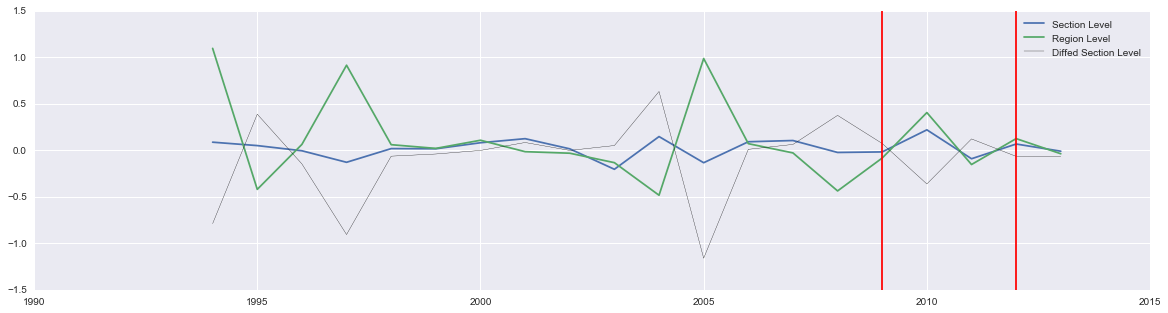

In [124]:
df = panel.sel(city='heredia').to_dataframe()
plt.figure(figsize=(20,5))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.region_sum_lum.pct_change(), label='Region Level')
plt.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black', lw=.3)
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')

plt.legend()
plt.show()

In [125]:
%%R
library('dynlm')
library('vars')

In [129]:
city = df[['inflation','imports','exports','sum_lum','earthquake_dummy','country_sum_lum','region_sum_lum']]
for c in ['country_sum_lum','region_sum_lum','sum_lum','exports','inflation']:
    city[c] = city[c].pct_change()
    
city = city.drop(1993)
city = city.drop(1994)
city['diffed_sum_lum'] = city['sum_lum'] - city['region_sum_lum']
city = city[['diffed_sum_lum','earthquake_dummy','inflation','imports','exports']]

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [132]:
%%R -i city
data <- city
data$earthquake_dummy <- as.numeric(data$earthquake_dummy)
# data <- log10(data)
data <- ts(data, start=c(1993), end=c(2013), frequency=1)
var <- VAR(data, p=2)
summary(var)


VAR Estimation Results:
Endogenous variables: diffed_sum_lum, earthquake_dummy, inflation, imports, exports 
Deterministic variables: const 
Sample size: 19 
Log Likelihood: 28.052 
Roots of the characteristic polynomial:
0.8992 0.8992 0.8349 0.8349 0.7488 0.7488 0.7247 0.7247 0.08203 0.08203
Call:
VAR(y = data, p = 2)


Estimation results for equation diffed_sum_lum: 
diffed_sum_lum = diffed_sum_lum.l1 + earthquake_dummy.l1 + inflation.l1 + imports.l1 + exports.l1 + diffed_sum_lum.l2 + earthquake_dummy.l2 + inflation.l2 + imports.l2 + exports.l2 + const 

                     Estimate Std. Error t value Pr(>|t|)  
diffed_sum_lum.l1   -0.664001   0.343398  -1.934   0.0892 .
earthquake_dummy.l1 -0.069867   0.500882  -0.139   0.8925  
inflation.l1         0.707662   0.544750   1.299   0.2301  
imports.l1          -0.006381   0.064760  -0.099   0.9239  
exports.l1          -4.458665   4.259050  -1.047   0.3258  
diffed_sum_lum.l2   -0.438348   0.334858  -1.309   0.2269  
earthquake_dummy